# GNN Link Prediction — Model Evaluation

Evaluation of the knowledge-graph GNN for **(Pralsetinib, inhibits, Protein)** link prediction with a **train/test split** on known off-target edges. Metrics and figures are suitable for reporting (e.g. poster).

In [8]:
import sys
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Project root: assume notebook is in notebooks/; if cwd is project root, use it
_cwd = Path(".").resolve()
if (_cwd / "data" / "kg_nodes_final.csv").exists():
    PROJECT_ROOT = _cwd
else:
    PROJECT_ROOT = _cwd.parent
SCRIPT_DIR = PROJECT_ROOT / "scripts" / "modeling"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPT_DIR))

from kg_gnn_data import (
    get_positive_and_candidate_tails,
    get_protein_outcome_pairs,
    load_kg_graph,
    negative_sampling,
)
from kg_gnn_model import GCNLinkPredictor

# Poster-friendly style
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11
sns.set_theme(style="whitegrid", palette="husl")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## 1. Load data and train/test split

Load the KG and split known **(Pralsetinib, inhibits, Protein)** edges into train (80%) and test (20%) for evaluation.

In [9]:
DATA_DIR = PROJECT_ROOT / "data"
nodes_path = DATA_DIR / "kg_nodes_final.csv"
edges_path = DATA_DIR / "kg_edges_final.csv"
assert nodes_path.exists() and edges_path.exists(), "Run from repo with data/kg_nodes_final.csv and data/kg_edges_final.csv"

data, id_to_idx = load_kg_graph(nodes_path, edges_path)
idx_to_id = {v: k for k, v in id_to_idx.items()}

positive_tails, candidate_tails, drug_idx = get_positive_and_candidate_tails(
    edges_path, id_to_idx, nodes_path
)
n_pos = len(positive_tails)
assert n_pos > 0, "No positive (Pralsetinib, inhibits, protein) edges found."

# Train/test split: hold out 20% + 1 extra protein edge
test_frac = 0.2
n_test = max(1, int(round(test_frac * n_pos))) + 1
indices = list(range(n_pos))
random.shuffle(indices)
train_pos = [positive_tails[i] for i in indices[n_test:]]
test_pos = [positive_tails[i] for i in indices[:n_test]]

print(f"Known positives: {n_pos}")
print(f"Train: {len(train_pos)}  |  Test (held-out): {len(test_pos)}")
print(f"Candidate proteins (ranking pool): {len(candidate_tails)}")

Known positives: 13
Train: 9  |  Test (held-out): 4
Candidate proteins (ranking pool): 516


## 2. Train GNN on training set only

Negative sampling uses only non-positive candidates. Outcome (protein–outcome) auxiliary task is optional.

In [10]:
# Negatives for training (exclude all known positives so test set is never used in loss)
neg_pairs = negative_sampling(
    drug_idx, train_pos, candidate_tails,
    num_negatives_per_positive=5, seed=SEED,
)
neg_tail_indices = [p[1] for p in neg_pairs]

# Optional outcome task (same as main script)
outcome_pos_pairs, candidate_outcomes, protein_to_outcomes = get_protein_outcome_pairs(
    edges_path, id_to_idx, nodes_path
)
outcome_neg_src, outcome_neg_dst = [], []
outcome_pos_pairs_matched = []
if outcome_pos_pairs and candidate_outcomes:
    outcome_set = set(candidate_outcomes)
    for (p, o) in outcome_pos_pairs:
        pos_out = protein_to_outcomes.get(p, set())
        neg_candidates = [x for x in outcome_set if x not in pos_out]
        if neg_candidates:
            outcome_pos_pairs_matched.append((p, o))
            outcome_neg_src.append(p)
            outcome_neg_dst.append(random.choice(neg_candidates))
    if len(outcome_pos_pairs_matched) > 2000:
        idx = random.sample(range(len(outcome_pos_pairs_matched)), 2000)
        outcome_pos_pairs_matched = [outcome_pos_pairs_matched[i] for i in idx]
        outcome_neg_src = [outcome_neg_src[i] for i in idx]
        outcome_neg_dst = [outcome_neg_dst[i] for i in idx]
    use_outcome_task = len(outcome_pos_pairs_matched) > 0
else:
    use_outcome_task = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_gpu = data.to(device)
in_channels = data_gpu.x.size(1)
model = GCNLinkPredictor(
    in_channels=in_channels, hidden_channels=64, out_channels=32,
    num_layers=2, dropout=0.3,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

pos_tensor = torch.tensor(train_pos, dtype=torch.long, device=device)
neg_tensor = torch.tensor(neg_tail_indices, dtype=torch.long, device=device)
if use_outcome_task:
    pos_src_t = torch.tensor([p for p, _ in outcome_pos_pairs_matched], dtype=torch.long, device=device)
    pos_dst_t = torch.tensor([o for _, o in outcome_pos_pairs_matched], dtype=torch.long, device=device)
    neg_src_t = torch.tensor(outcome_neg_src, dtype=torch.long, device=device)
    neg_dst_t = torch.tensor(outcome_neg_dst, dtype=torch.long, device=device)

epochs = 200
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    h = model(data_gpu)
    loss = model.loss_batch(h, drug_idx, pos_tensor, neg_tensor)
    if use_outcome_task:
        loss = loss + 0.5 * model.loss_outcome_batch(h, pos_src_t, pos_dst_t, neg_src_t, neg_dst_t)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0 or epoch == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, loss = {loss.item():.4f}")
print("Training done.")

Epoch 1/200, loss = 1.0608
Epoch 50/200, loss = 0.2305
Epoch 100/200, loss = 0.1738
Epoch 150/200, loss = 0.1584
Epoch 200/200, loss = 0.1813
Training done.


## 3. Evaluate on held-out test set

Score all candidate proteins and compute where held-out positives rank. Then compute **Recall@k**, **MRR**, and rank statistics.

In [11]:
model.eval()
with torch.no_grad():
    h = model(data_gpu)
    cand_tensor = torch.tensor(candidate_tails, dtype=torch.long, device=device)
    scores = model.predict_link(h, drug_idx, cand_tensor)
    scores_np = scores.cpu().numpy()

# Rank order (descending score)
order = scores_np.argsort()[::-1]  # indices into candidate_tails
test_set = set(test_pos)

# For each test positive, get its 1-based rank (or None if not in candidates)
pos_to_rank = {}
for rank_1based, idx in enumerate(order, start=1):
    tail_idx = candidate_tails[idx]
    if tail_idx in test_set and tail_idx not in pos_to_rank:
        pos_to_rank[tail_idx] = rank_1based
    if len(pos_to_rank) == len(test_set):
        break

# Ranks of test positives (use n_candidates+1 for unranked)
n_candidates = len(candidate_tails)
ranks = [pos_to_rank.get(p, n_candidates + 1) for p in test_pos]

# Metrics (Recall@k only up to k=20)
k_list = [5, 10, 20]
recall_at_k = {}
for k in k_list:
    recall_at_k[k] = sum(1 for r in ranks if r <= k) / len(test_pos) if test_pos else 0.0

# MRR: mean of 1/rank
mrr = np.mean([1.0 / r for r in ranks]) if ranks else 0.0
mean_rank = np.mean(ranks)
median_rank = np.median(ranks)

# Store for tables/plots
metrics_summary = {
    "Recall@5": recall_at_k[5],
    "Recall@10": recall_at_k[10],
    "Recall@20": recall_at_k[20],
    "MRR": mrr,
    "Mean rank": mean_rank,
    "Median rank": median_rank,
}
print("Test set metrics:")
for name, val in metrics_summary.items():
    if "Recall" in name or "MRR" in name:
        print(f"  {name}: {val:.3f}")
    else:
        print(f"  {name}: {val:.1f}")

Test set metrics:
  Recall@5: 0.250
  Recall@10: 0.750
  Recall@20: 1.000
  MRR: 0.143
  Mean rank: 9.2
  Median rank: 7.5


## 4. Poster-ready summary table

Styled metrics table suitable for a report or poster.

In [12]:
# Summary table for poster/report
df_metrics = pd.DataFrame([
    {"Metric": "Train size", "Value": f"{len(train_pos)}"},
    {"Metric": "Test size (held-out)", "Value": f"{len(test_pos)}"},
    {"Metric": "Recall@5", "Value": f"{metrics_summary['Recall@5']:.2%}"},
    {"Metric": "Recall@10", "Value": f"{metrics_summary['Recall@10']:.2%}"},
    {"Metric": "Recall@20", "Value": f"{metrics_summary['Recall@20']:.2%}"},
    {"Metric": "MRR", "Value": f"{metrics_summary['MRR']:.3f}"},
    {"Metric": "Mean rank (test)", "Value": f"{metrics_summary['Mean rank']:.1f}"},
    {"Metric": "Median rank (test)", "Value": f"{metrics_summary['Median rank']:.1f}"},
])
df_metrics.style.set_properties(**{"text-align": "left"}).set_table_styles([
    {"selector": "th", "props": [("font-weight", "bold"), ("background-color", "#f0f0f0")]},
])

,Metric,Value
0,Train size,9
1,Test size (held-out),4
2,Recall@5,25.00%
3,Recall@10,75.00%
4,Recall@20,100.00%
5,MRR,0.143
6,Mean rank (test),9.2
7,Median rank (test),7.5


## 5. Visualizations for poster

**Left:** Recall@k bar chart. **Right:** Rank distribution of held-out test positives.

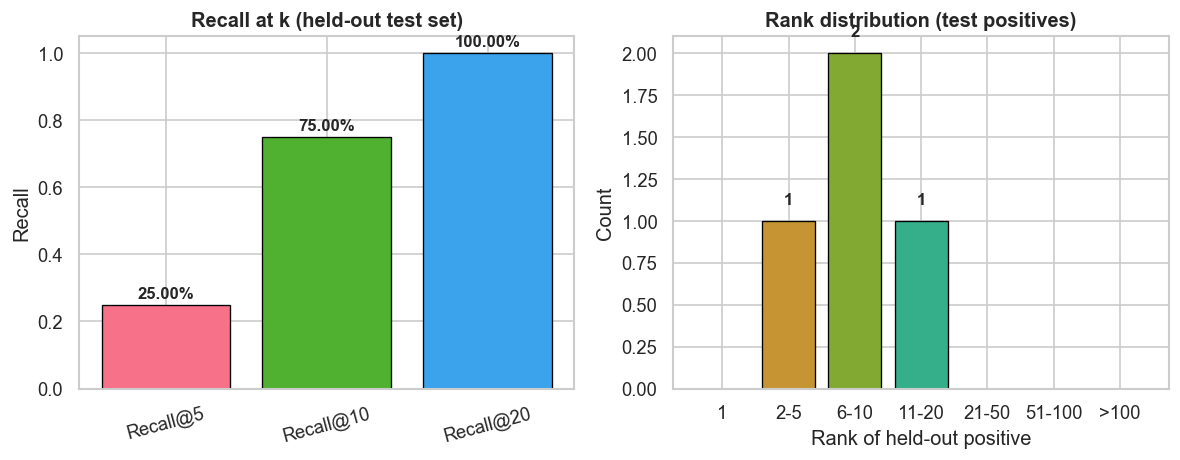

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Recall@k bar chart
ax1 = axes[0]
x = [f"Recall@{k}" for k in k_list]
y = [recall_at_k[k] for k in k_list]
bars = ax1.bar(x, y, color=sns.color_palette("husl", len(k_list)), edgecolor="black", linewidth=0.8)
ax1.set_ylabel("Recall", fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.set_title("Recall at k (held-out test set)", fontsize=12, fontweight="bold")
for b, v in zip(bars, y):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold")
ax1.tick_params(axis="x", rotation=15)

# Rank distribution (test positives)
ax2 = axes[1]
def bucket_rank(r):
    if r <= 1: return 0
    if r <= 5: return 1
    if r <= 10: return 2
    if r <= 20: return 3
    if r <= 50: return 4
    if r <= 100: return 5
    return 6
rank_labels = ["1", "2-5", "6-10", "11-20", "21-50", "51-100", ">100"]
counts = [sum(1 for r in ranks if bucket_rank(r) == i) for i in range(7)]
colors = sns.color_palette("husl", len(rank_labels))
bars2 = ax2.bar(rank_labels, counts, color=colors, edgecolor="black", linewidth=0.8)
ax2.set_xlabel("Rank of held-out positive", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title("Rank distribution (test positives)", fontsize=12, fontweight="bold")
for b, c in zip(bars2, counts):
    if c > 0:
        ax2.text(b.get_x() + b.get_width()/2, b.get_height() + 0.1, str(c), ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

## 6. Recall@k curve (line plot)

Classic link-prediction plot: recall as a function of k. Good for comparing models or for a methods figure.

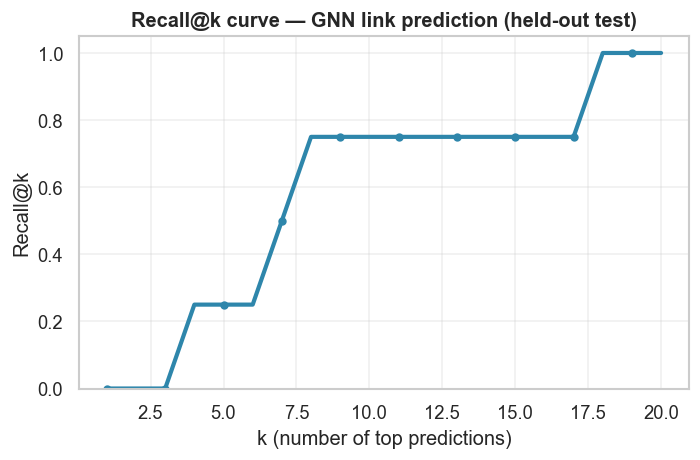

In [14]:
# Recall@k for k = 1 .. 20
k_range = list(range(1, min(21, n_candidates + 1)))
recall_curve = [sum(1 for r in ranks if r <= k) / len(test_pos) for k in k_range] if test_pos else [0.0] * len(k_range)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_range, recall_curve, color="#2e86ab", linewidth=2.5, marker="o", markersize=4, markevery=2)
ax.set_xlabel("k (number of top predictions)", fontsize=12)
ax.set_ylabel("Recall@k", fontsize=12)
ax.set_title("Recall@k curve — GNN link prediction (held-out test)", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()